# Automated diagnosis for pneumonia

## Imports

In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

Using TensorFlow backend.
c:\dev\machine_learning_course\automated_diagnosis\ad_venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\dev\machine_learning_course\automated_diagnosis\ad_venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\dev\machine_learning_course\automated_diagnosis\ad_venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12474148297486611627
]


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

## Data

#### Parameters

In [4]:
INPUT_PATH = 'input_data'
DATASET = 'chest_xray'
DATA = os.path.join(INPUT_PATH, DATASET)

#### Loading

In [5]:
for root, dirs, files in os.walk(DATA):
    depth = len(root.split(os.sep)) - 1
    print('  ' * depth, '+ ' + os.path.basename(root), '(' + (str(len(files)) + ' files)') if len(files) else '')

   + chest_xray 
     + test 
       + NORMAL (234 files)
       + PNEUMONIA (390 files)
     + train 
       + NORMAL (1341 files)
       + PNEUMONIA (3875 files)
     + val 
       + NORMAL (8 files)
       + PNEUMONIA (8 files)


In [6]:
train_dir = os.path.join(DATA, 'train')
test_dir = os.path.join(DATA, 'test')
val_dir = os.path.join(DATA, 'val')

### Exploration

In [7]:
def plot_9_images(path, labeled=False):
    all_image_files = list(filter(lambda x: x.endswith('.jpeg'), os.listdir(path)))
    fig = plt.figure(figsize=(18, 12))

    for iteration in range(9):
        file = all_image_files[iteration]
        img = mpimg.imread(os.path.join(path, file))
        plt.subplot(331 + iteration)
        if labeled:
            plt.title(file.split('_')[1])
        plt.imshow(img)

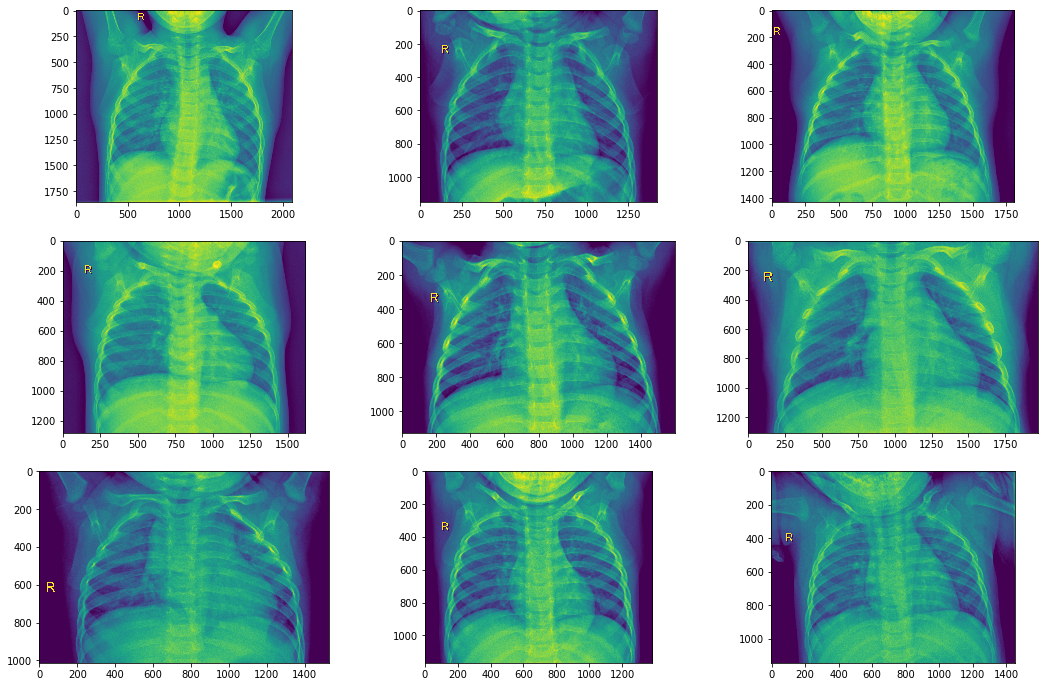

In [8]:
plot_9_images(train_dir + '/NORMAL')

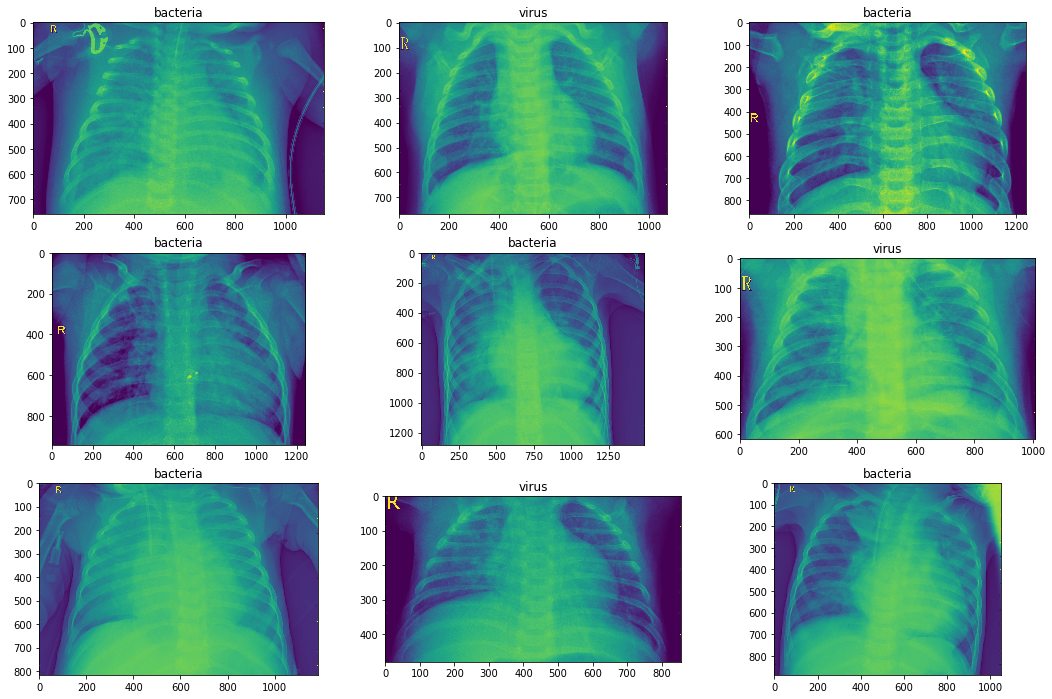

In [9]:
plot_9_images(train_dir + '/PNEUMONIA', labeled=True)

#### Processing

In [10]:
rescale = 1./255
target_size = (150, 150)
class_mode = 'categorical'
batch_size = 64

train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=target_size,
                                                              class_mode=class_mode,
                                                              batch_size=batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Modeling

In [11]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
     layer.trainable = False

x = base_model.output
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

predictions = keras.layers.Dense(2, activation='sigmoid')(x)

model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

In [12]:
history = model.fit_generator(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
82/82 [==============================] - 95s 1s/step - loss: 0.3400 - accuracy: 0.8457 - val_loss: 0.8816 - val_accuracy: 0.6875
Epoch 2/10
82/82 [==============================] - 94s 1s/step - loss: 0.2393 - accuracy: 0.9028 - val_loss: 0.6998 - val_accuracy: 0.6250
Epoch 3/10
82/82 [==============================] - 94s 1s/step - loss: 0.2077 - accuracy: 0.9153 - val_loss: 0.7492 - val_accuracy: 0.6250
Epoch 4/10
82/82 [==============================] - 95s 1s/step - loss: 0.2119 - accuracy: 0.9141 - val_loss: 1.0080 - val_accuracy: 0.6875
Epoch 5/10
82/82 [==============================] - 94s 1s/step - loss: 0.2115 - accuracy: 0.9107 - val_loss: 1.0395 - val_accuracy: 0.7500
Epoch 6/10
82/82 [==============================] - 96s 1s/step - loss: 0.2009 - accuracy: 0.9178 - val_loss: 1.7287 - val_accuracy: 0.6250
Epoch 7/10
82/82 [==============================] - 95s 1s/step -

## Results

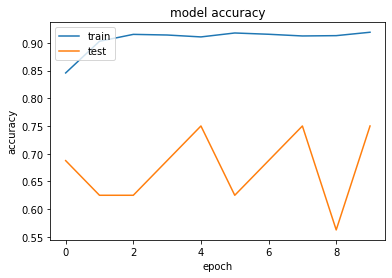

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

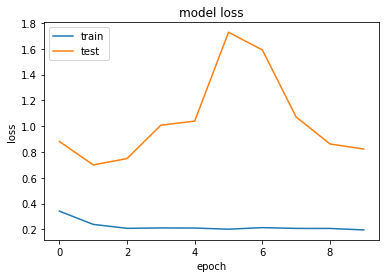

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1]*100, '%')

10/10 [==============================] - 12s 1s/step
Loss: 0.8683624267578125
Accuracy: 72.43589758872986 %


In [16]:
model.save('model_01.h5')